# O problema da função lógica XOR

Neste exemplo, veremos que um único perceptron não é capaz de resolver o problema da lógica XOR, ou seja, separar as classes desta lógica.

In [ ]:
# Import all necessary libraries.
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Reset PN sequence generator.
seed = 8
np.random.seed(seed)

## Gerando o conjunto de dados com 2 classes.

+ Este exemplo apresenta a classificação de dados ruidosos e que **não são linearmente separáveis**.


+ A base de dados é gerada a partir da função lógica XOR com ruído Gaussiano adicionado às amostras.


+ Como veremos, o perceptron não consegue classificar perfeitamente o conjunto de dados.

In [ ]:
# Number of examples.
N = 1000

# Create attributes. A função randint não tem o limite superior fechado.
x1 = np.random.randint(0, 2, N, dtype=bool).reshape(N,1)
x2 = np.random.randint(0, 2, N, dtype=bool).reshape(N,1)

# Target function (XOR function: operação bit a bit).
y = x1 ^ x2

# Add noise to the attributes.
x1 = x1 + 0.1*np.random.randn(N, 1)
x2 = x2 + 0.1*np.random.randn(N, 1)

# Concatenate attribute vectors into a matrix.
X = np.c_[x1, x2]

### Plotando as 2 classes.

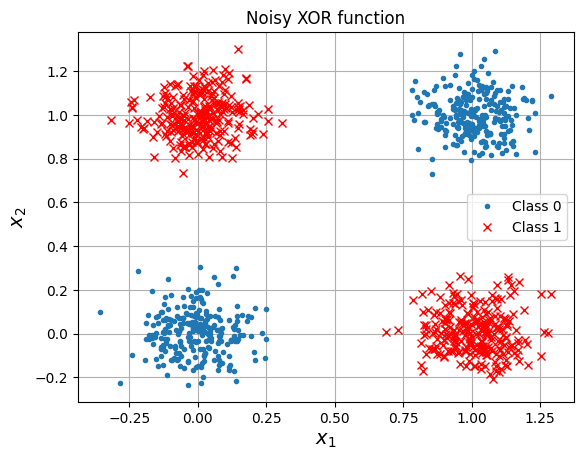

In [ ]:
idx0 = np.argwhere(y.ravel() == 0)
idx1 = np.argwhere(y.ravel() == 1)

plt.plot(x1[idx0.ravel()], x2[idx0.ravel()], '.', label='Class 0')
plt.plot(x1[idx1.ravel()], x2[idx1.ravel()], 'rx', label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Noisy XOR function')
plt.legend()
plt.grid()
plt.show()

**OBS**.: Percebam que não conseguimos separar as duas classes com um separador linear.

### Criando as matrizes de atributos de treinamento e validação.

Por definição, as matrizes de atributos que serão passadas para o perceptron seguem o formato de um plano

$$g(\textbf{x}) = \hat{a}_0 + \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

Lembrem-se que está equação se torna uma reta quando $g(\textbf{x})=0$ e a plotamos no espaço criado pelos atributos, $x_1$ e $x_2$.
<br/><br/>

Portanto, devemos concatenar o vetor do atributo de bias (i.e., vetor com todos os valores iguais a 1) às matrizes de atributos originais ou configurar o parâmetro `fit_intercept=True`.
<br/><br/>

Dividimos o conjunto total de dados em 70% para treinamento e 30% para validação.

In [ ]:
# Split array into random train and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

## Treinando um Perceptron.

+ A biblioteca SciKit-Learn implementa um perceptron através da classe `Perceptron`.
<br/>

+ Portanto, instanciamos um objeto da classe `Perceptron` do módulo `linear_model` da biblioteca SciKit-Learn.
<br/>

+ Instanciamos a classe com todos os parâmetros com seus valores padrão, incluindo o parâmetro `fit_intercept=True`, pois queremos que o vetor de bias seja adicionado às matrizes de atributo pela própria classe.
<br/>

+ O parâmetro `random_state` é configurado com a semente definida no início do exemplo. Assim, o embaralhamento aplicado ao conjunto de treinamento será sempre o mesmo, independentemente da vez em que executamos esse notebook.
<br/>

+ A documentação da classe `Perceptron` pode ser encontrada em: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron

In [ ]:
# Instantiate the perceptron object.
per = Perceptron(random_state=seed)

# Treinando o modelo. O método ravel transforma o vetor em uma array unidimensional.
per.fit(X_train, y_train.ravel())

Perceptron(random_state=8)

**Observação**

+ O treinamento do `Perceptron` é encerrado quando `erro_atual > erro_anterior - tol`. Por padrão, `tol=1e-3`.
<br/>

+ O atributo `n_iter_` da classe `Perceptron` mostra quantas épocas foram necessárias para se atingir o critério de parada.

In [ ]:
print('Épocas até a parada do treinamento:', per.n_iter_)

Épocas até a parada do treinamento: 6


### Calculando a acurácia do classificador.

Usamos o conjunto de validação para calcular a acurácia.

In [ ]:
# Calculate accuracy of class predictions.
y_pred = per.predict(X_test)

# SciKit-Learn's function. Imported from metrics module.
acc = accuracy_score(y_test, y_pred)
print('Acurácia:', acc)

Acurácia: 0.62


### Plotando as regiões de decisão.

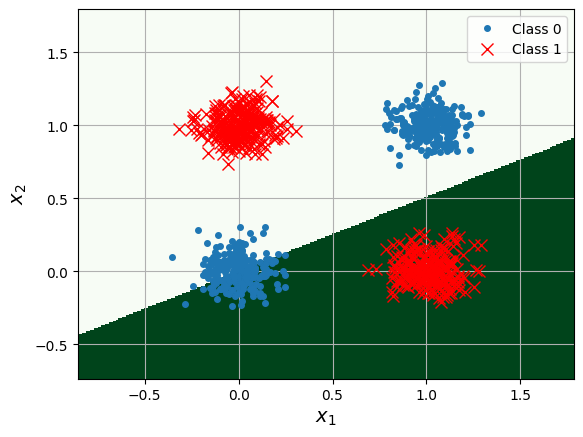

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape as the one created for the training.
attribute_matrix = np.c_[xx.ravel(), yy.ravel()]

Z = per.predict(attribute_matrix)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', markersize=8, label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', markersize=8, label='Class 1')
plt.legend()
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()

plt.show()

**Observações**:

+ Essa é uma possível solução que atende ao critério de parada estabelecido durante a criação do objeto da classe `Perceptron`.
<br/>

+ Se alterarmos a semente, o resultado será, muito provavelmente, outro.

### Gerando a matriz de confusão

Usamos novamente o conjunto de validação (ou teste) para plotar a matriz de confusão.

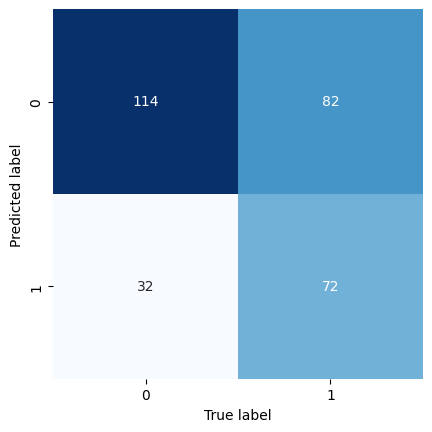

In [ ]:
# Predict.
y_pred = per.predict(X_test)

# Plot the confusion matrix.
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=range(2), yticklabels=range(2), cmap="Blues")
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

### Observações

+ Mesmo sendo suficientemente espaçadas, as duas classes **não podem ser sepraradas por um hiperplano**.
<br/>

+ Portanto, como o perceptron, por definição, usa uma função discriminante linear, não é possível separar as classes.
<br/>

+ Nós poderíamos utilizar funções discriminantes não-lineares como usamos antes, mas veremos uma outra maneira que pode ser usada em **casos onde não conseguimos plotar as classes e identificar o formato necessário para a função discriminante**.
<br/>

+ Com esta outra maneira, iremos **combinar os resultados de perceptrons com funções discriminantes lineares** e, a partir desta combinação, **obter um modelo de classificação não-linear**.
<br/>

+ Esta combinação de perceptrons será nosso primeiro contato com **redes neurais**, que nada mais são do que **combinações de perceptrons (i.e., neurônios)**.

## Combinando três perceptrons.

+ Para resolvermos o problema da função lógica XOR com um classificador, reescrevemos a operação através da seguinte expressão lógica:

```python
A ^ B = (A & ~B)  |  (~A & B)
```

+ `&`, `|` e `~` são as operações lógicas AND, OR e complemento, respectivamente.
<br/>

+ Observando a expressão, verificamos que existem **três operações principais**: duas operações lógicas AND e uma OR.
    + O complemento só altera a localização da função discriminante, mas o problema continua sendo linearmente separável.
<br/>

+ Sabemos que essas duas operações lógicas (AND e OR) podem ser implementadas por classificadores lineares, pois os dados são **linearmente separáveis**.
<br/>

+ Portanto, como podemos representar a lógica XOR através de funções mais simples que são linearmente separáveis, podemos **treinar individualmente** três perceptrons diferentes para realizar cada uma destas operações e ao final **combinar seus resultados** para se obter a classificação da função lógica XOR.
<br/>

+ A figura abaixo mostra a combinação dos três perceptrons.

<img src="https://github.com/zz4fap/t320_aprendizado_de_maquina/blob/main/figures/xor_perceptrons.png?raw=1" width="800px">

### Gerando o conjunto de dados.

Regero os dados para criar os atributos e rótulos necessários para o treinamento de cada `Perceptron`.

In [ ]:
# Number of examples.
N = 1000

# Reset PN sequence generator.
np.random.seed(seed)

# Create attributes.
x1 = np.random.randint(0, 2, N, dtype=bool).reshape(N,1)
x2 = np.random.randint(0, 2, N, dtype=bool).reshape(N,1)

# Target function (XOR function: operação bit a bit).
y = x1 ^ x2

# Labels of the first perceptron.
y1 = x1 & (~x2)

# Labels of the second perceptron.
y2 = (~x1) & x2

# Attributes and labels of the third perceptron.
X3 = np.c_[y1, y2]
y3 = y1 | y2

# Add noise to the attributes.
x1 = x1 + 0.1*np.random.randn(N,1)
x2 = x2 + 0.1*np.random.randn(N,1)

# Concatenate attributes into the attribute matrix (entradas do primeiro e segundo perceptrons).
X = np.c_[x1, x2]

### Plotando as 2 classes.

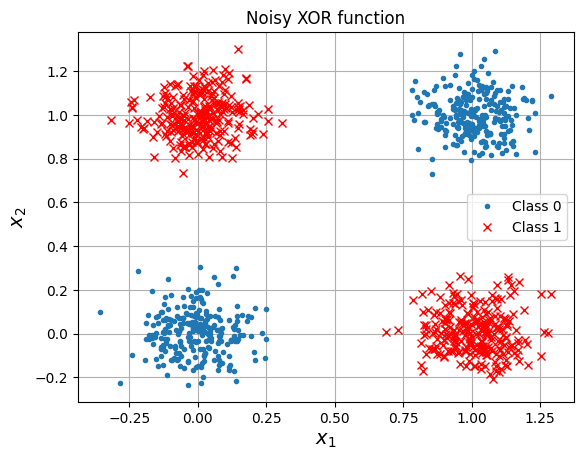

In [ ]:
idx0 = np.argwhere(y3.ravel() == 0)
idx1 = np.argwhere(y3.ravel() == 1)

plt.plot(x1[idx0.ravel()], x2[idx0.ravel()], '.', label='Class 0')
plt.plot(x1[idx1.ravel()], x2[idx1.ravel()], 'rx', label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Noisy XOR function')
plt.legend()
plt.grid()
plt.show()

### Criando as matrizes de atributos de treinamento e validação para o primeiro perceptron.

Por definição, as matrizes de atributos que serão passadas para o perceptron seguem o formato de um plano

$$g(\textbf{x}) = \hat{a}_0 + \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

Portanto, devemos concatenar o vetor do atributo de bias às matrizes de atributos originais ou configurar o parâmetro `fit_intercept=True`.

Dividimos o conjunto original em 70% para treinamento e 30% para validação.

In [ ]:
# Split array into random train and validation subsets.
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=seed)

### Treinamento do primeiro perceptron.

Este perceptron implementa a expressão:
```python
y1 = (x1 & ~x2)
```

**OBS**.: O parâmetro `fit_intercept` usa seu valor padrão, `True`, pois queremos que o vetor de bias seja adicionado às matrizes de atributo pela própria classe.

In [ ]:
# Instantiate perceptron 1.
per1 = Perceptron(random_state=seed)

# Train perceptron 1.
per1.fit(X1_train, y1_train.ravel())

# Calculate accuracy of class predictions.
y_pred1 = per1.predict(X1_test)

# Calculate accuracy.
acc = accuracy_score(y1_test, y_pred1)
print('Acurácia perceptron #1:', acc)

Acurácia perceptron #1: 1.0


### Criando as matrizes de atributos de treinamento e validação para o segundo perceptron.

Por definição, as matrizes de atributos que serão passadas para o perceptron seguem o formato de um plano

$$g(\textbf{x}) = \hat{a}_0 + \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

Portanto, devemos concatenar o vetor do atributo de bias às matrizes de atributos originais ou configurar o parâmetro `fit_intercept=True`.

Dividimos o conjunto original em 70% para treinamento e 30% para validação.

In [ ]:
# Split array into random train and validation subsets.
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=seed)

### Treinamento do segundo perceptron.

Este perceptron implementa a expressão:
```python
y2 = (~x1 & x2)
```

In [ ]:
# Instantiate perceptron 2.
per2 = Perceptron(random_state=seed)

# Train perceptron 2.
per2.fit(X2_train, y2_train.ravel())

# Calculate accuracy of class predictions.
y_pred2 = per2.predict(X2_test)

# Calculate accuracy.
acc = accuracy_score(y2_test, y_pred2)
print('Acurácia perceptron #2:', acc)

Acurácia perceptron #2: 1.0


### Criando as matrizes de atributos de treinamento e validação para o terceiro perceptron.

Por definição, as matrizes de atributos que serão passadas para o perceptron seguem o formato de um plano

$$g(\textbf{x}) = \hat{a}_0 + \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

Portanto, devemos concatenar o vetor do atributo de bias às matrizes de atributos originais ou configurar o parâmetro `fit_intercept=True`.

Dividimos o conjunto original em 70% para treinamento e 30% para validação.

In [ ]:
# Split array into random train and validation subsets.
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=seed)

### Treinamento do terceiro perceptron.

Este perceptron implementa a expressão:
```python
y3 = y1 | y2
```

In [ ]:
# Instantiate perceptron 3.
per3 = Perceptron(random_state=seed)

# Train perceptron 3.
per3.fit(X3_train, y3_train.ravel())

y_pred3 = per3.predict(X3_test)

# Calculate accuracy.
acc = accuracy_score(y3_test, y_pred3)
print('Acurácia perceptron #3:', acc)

Acurácia perceptron #3: 1.0


### Combinando os três perceptrons em um único classificador.

Criamos uma classe para combinar os três classificadores (i.e., perceptrons) em um único classificador.

In [ ]:
class Classifier():
    '''Classe que combina os três perceptrons, criando um classificador não linear.'''

    def __init__(self, per1, per2, per3):
        self.per1 = per1
        self.per2 = per2
        self.per3 = per3

    def predict(self, X):
        y1 = self.per1.predict(X)
        y2 = self.per2.predict(X)
        X3 = np.c_[y1, y2]
        y3 = self.per3.predict(X3)
        return y3

### Usando a combinação dos três perceptrons para classificar as amostras da função lógica XOR.

Utilizaremos todas as amostras geradas.

In [ ]:
# Instantiate an object of the class Classifier.
clf = Classifier(per1, per2, per3)

# Perform prediction on the whole dataset.
y_pred = clf.predict(X)

# Calculate accuracy.
acc = accuracy_score(y, y_pred)
print('Acurácia da combinação dos 3 perceptrons:', acc)

Acurácia da combinação dos 3 perceptrons: 1.0


### Plotando as regiões de decisão.

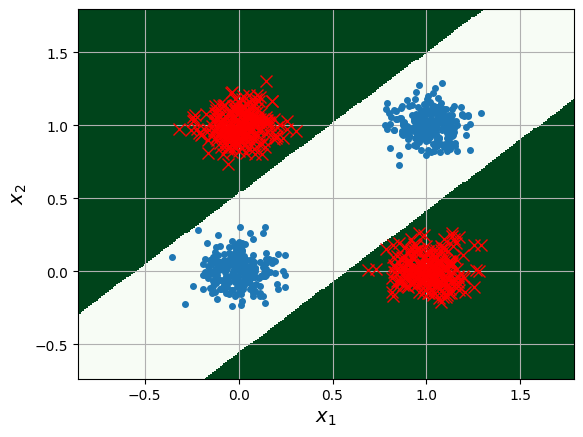

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape
# as the one created for the training.
attribute_matrix = np.c_[xx.ravel(), yy.ravel()]

Z = clf.predict(attribute_matrix)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', markersize=8, label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', markersize=8, label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()

plt.show()

**OBS**.:

+ O resultado final é um **classificador não linear** que é a **combinação dos resultados individuais de dois classificadores lineares**.

### Gerando a matriz de confusão

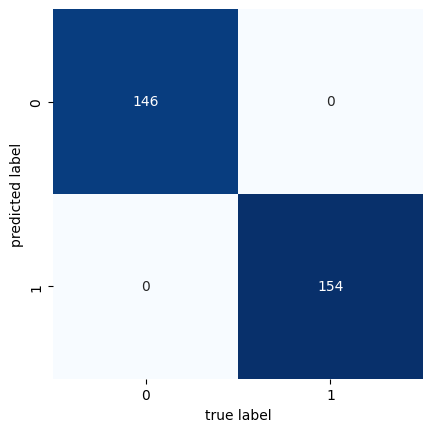

In [ ]:
 # Predict.
y_pred = clf.predict(X_test)

# Plot the confusion matrix.
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=range(2), yticklabels=range(2), cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Observações

+ Neste exemplo, conseguimos **treinar os três perceptrons de forma independente**, pois, felizmente, a **função lógica XOR pode ser implementada em termos de funções mais simples**, as quais aceitam separadores lineares.
<br/>

+ A combinação dos três perceptrons, com funções discriminantes lineares, resultou em uma função discriminante não-linear.
<br/>

+ A ideia por trás das redes neurais é esta, **combinar os resultados de vários perceptrons de forma que encontremos as funções necessárias para se resolver o problema em mãos: regressão ou classificação**, por exemplo.
    * Mais adiante, quando usarmos funções de ativação diferentes da rígida, chamaremos os perceptrons de **neurônios**.
<br/>

+ Porém, como fazer para treinar combinações de perceptrons quando não podemos treiná-los de forma independente?
<br/>

+ Ou seja, e se tivermos **apenas as entradas e as saídas esperadas e não soubermos quais são os valores de saída intermediários dos perceptrons**?
<br/>

+ Veremos em breve, que **os neurônios das redes neurais são treinados em conjunto**, utilizando um **algoritmo baseado no gradiente descendente que propaga o erro da camada de saída para as camadas mais internas até a camada de entrada da rede** fazendo com que os pesos dos diversos neurônios sejam atualizados e, que consequentemente, a rede neural aprenda a resolver o problema.
<br/>

+ Este algoritmo é chamado de **error backpropagation** ou, em português, **retropropagação do erro**.